# High-dimensional Gaussian sampling:  A review and a unifying approach based on a stochastic proximal point algorithm

##### Corresponding author: [Maxime Vono](https://mvono.github.io/)

See also
- the [documentation](https://pygauss-gaussian-sampling.readthedocs.io/en/latest/) on ReadTheDocs,
- the [companion paper](https://arxiv.org/pdf/2010.01510.pdf) publicy available on ArXiv and accepted for publication in SIAM Review.

## Table of contents

1. [Figure 1](#Figure-1)
2. [Figure 2](#Figure-2)
3. [Figure 3](#Figure-3)
4. [Figure 5](#Figure-5)
5. [Figure 6](#Figure-6)
6. [Figure 7](#Figure-7)
7. [Figure 8](#Figure-8)
8. [Figure 9](#Figure-9)
9. [Table 8](#Table-8)
10. [Figure 10](#Figure-10)
11. [Figure 11](#Figure-11)

## Imports

In [1]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from pygauss import mcmc_sampling, direct_sampling
import numpy as np
import pandas as pd
import pyreadr
import matplotlib.pyplot as plt
from scipy.linalg import circulant, dft
from timeit import default_timer as timer
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.covariance import EmpiricalCovariance
from itertools import product
import pymc3 as pm
import math
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib import cm
import scipy as sp

class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))
    
class MidPointLogNorm(mpl.colors.LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        mpl.colors.LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))


%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Figure 1

([], <a list of 0 Text yticklabel objects>)

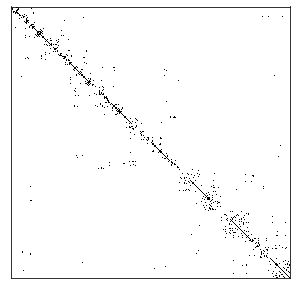

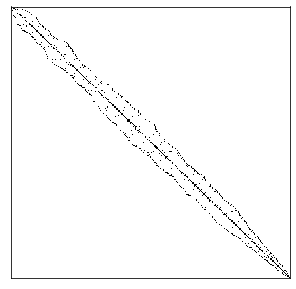

In [11]:
d = 544
Q = pyreadr.read_r('data/Q.rdata')['Qmat']
Q = np.reshape(Q.values,(d,d))

Q1 = pyreadr.read_r('data/Q1.rdata')['Q1']
Q1[Q1==544] = 1
Q1 = np.reshape(Q1.values,(d,d))

plt.figure(figsize=(5,5))
plt.imshow(Q,aspect='auto',cmap='Greys')
plt.xticks([], [])
plt.yticks([], [])

plt.figure(figsize=(5,5))
plt.imshow(Q1,aspect='auto',cmap='Greys')
plt.xticks([], [])
plt.yticks([], [])

## Figure 2

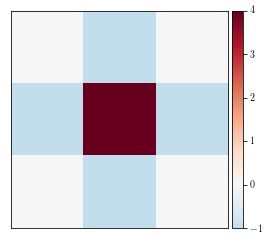

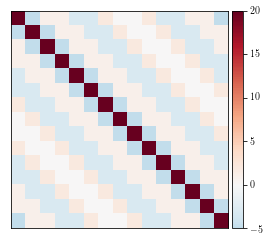

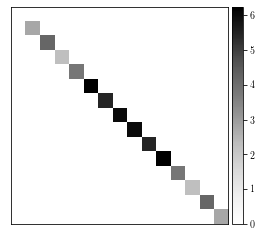

In [32]:
# Build kernel for edge detection
d = np.array([4,-1,0,0,-1,0,0,0,0,0,-1,0,0,0,-1])
D = circulant(d)
Q = np.dot(D.T,D)

# Build the Laplace filter
f = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])

# Plot the 2D-Laplace filter
vmin = 4
vmax = -1
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
plt.figure()
plt.xticks([], [])
plt.yticks([], [])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(f,cmap='RdBu_r',norm=norm)
cb = plt.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=10)

# Plot the circulant precision matrix Q = D^T.D
vmin = 20
vmax = -5
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

plt.figure()
plt.xticks([], [])
plt.yticks([], [])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(Q,cmap='RdBu_r',norm=norm)
cb = plt.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=10)

# Plot the diagonal matrix F.Q.F^H in the Fourier domain
N = len(d)
F = dft(N)
Lamb = np.dot(F,d)

plt.figure()
plt.xticks([], [])
plt.yticks([], [])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(np.diag(np.abs(Lamb)),cmap='Greys')
cb = plt.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=10)

## Figure 3

### MNIST dataset

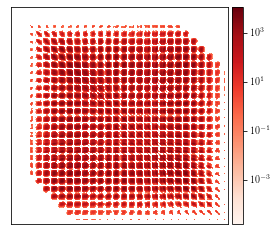

In [31]:
def preprocessing(x_train,x_test,y_train,y_test,c1,c2):

    # Making sure that the values are float so that we can get decimal points 
    # after division
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    y_train = y_train.astype('int')
    y_test = y_test.astype('int')

    # Normalizing the RGB codes by dividing it to the max RGB value.
    x_train /= 255
    x_test /= 255

    # Select the classes to classify for binary logistic regression
    i1 = np.where((y_train == c1) | (y_train == c2))
    y1_train = y_train[i1]
    x1_train = x_train[i1]
    i1 = np.where((y_test == c1) | (y_test == c2))
    y1_test = y_test[i1]
    x1_test = x_test[i1]

    # Data processing
    # Reshape the 2D-images into 1D-vectors
    d1 = np.size(x1_train,0)
    d2 = np.size(x1_train,1)
    x1_train = np.reshape(x1_train,[d1,d2**2])
    X1_train = np.concatenate((np.ones((d1,1)),x1_train),axis=1)
    d1 = np.size(x1_test,0)
    d2 = np.size(x1_test,1)
    x1_test = np.reshape(x1_test,[d1,d2**2])
    X1_test = np.concatenate((np.ones((d1,1)),x1_test),axis=1)

    # Replace labels of the current class with 1 and other labels with 0
    i1 = np.where(y1_train == c1)
    i2 = np.where(y1_train == c2)
    y1_train[i1] = 1
    y1_train[i2] = 0
    i1 = np.where(y1_test == c1)
    i2 = np.where(y1_test == c2)
    y1_test[i1] = 1
    y1_test[i2] = 0
    
    # Return objects of interest
    return X1_train, X1_test, y1_train, y1_test;

# Vector of classes to compare
c1 = 5
c2 = 3 


# Load the dataset
    
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    

# Data processing
    
X1_train, X1_test, y1_train, y1_test = preprocessing(x_train,x_test,y_train,y_test,c1,c2)

plt.figure()
plt.xticks([], [])
plt.yticks([], [])
ax = plt.gca()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(np.dot(X1_train.T,X1_train),aspect='equal',cmap='Reds',norm=LogNorm())
cb = plt.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=10)

### leukemia dataset

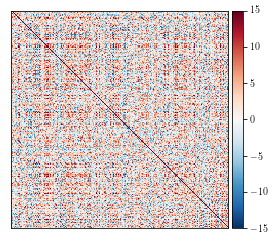

In [29]:
A = pd.read_csv('data/armstrong.txt', delimiter = '\t')
X = A[A.columns[2:22]]
X = X.T
X = X[X.columns[0:5000]]
X = (X - X.mean()) / X.std()

vmin = -15
vmax = 15
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

plt.figure()
plt.xticks([], [])
plt.yticks([], [])
ax = plt.gca()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(np.dot(X.T,X),aspect='equal',cmap='RdBu_r',norm=norm)
cb = plt.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=10)

### CoEPrA dataset

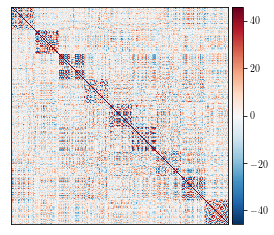

In [30]:
A = pd.read_csv('data/CoEPrA.txt', delimiter = ',')
X = A[A.columns[0:5786]]
X = (X - X.mean()) / X.std()

plt.figure()
plt.xticks([], [])
plt.yticks([], [])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(np.dot(X.T,X),aspect='equal',cmap='RdBu_r')
cb = plt.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=10)

## Figure 5

#### Covariance matrix $\Sigma$

<ipython-input-74-6635a1bf2e37>:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))


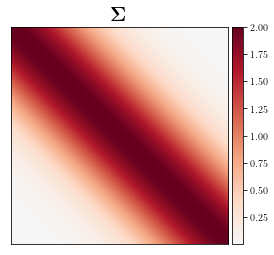

In [75]:
# Set random seed
np.random.seed(94)

# Build the matrix A and its inverse for d = 100
d = 100
A = np.zeros((d,d))
a = 1.5
eps = 1e-6
s = np.linspace(-3,3,num=d)
for i in range(d):
    for j in range(d):
        if i == j:
            A[i,j] = 2 + eps
        else:
            A[i,j] = 2 * np.exp(-(s[i]-s[j])**2 / (2 * a**2))

invA = np.linalg.inv(A)   
            
# Show A
vmin = np.min(A)
vmax = np.max(A)
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
plt.figure()
plt.xticks([], [])
plt.yticks([], [])
plt.title(r"$\mathbf{\Sigma}$",size=20)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(A,aspect='equal',norm=norm,cmap='RdBu_r')
cb = plt.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=10)

#### Residuals

Sampling done for d = 100.
Sampling done for size = 100000.


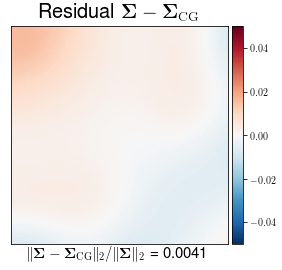

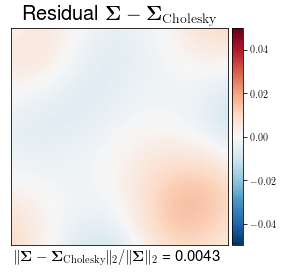

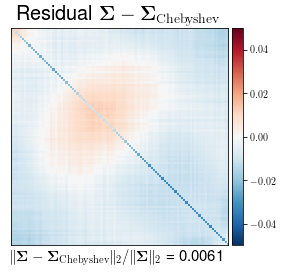

In [35]:
# Set seed
np.random.seed(90)
S = [100000]
D = [100]

# Initialization
err_CG = np.zeros(len(D))
err_Chol = np.zeros(len(D))
err_Cheby = np.zeros(len(D))
K_Cheby = np.zeros((len(S),len(D)))

Time = np.zeros((3,len(S),len(D)))

eig_CG = np.zeros(100)
eig_Chol = np.zeros(100)
eig_Cheby = np.zeros(100)

for t in range(len(S)):
    for i in range(len(D)):

        size = S[t]
        d = D[i]
        A = np.zeros((d,d))
        a = 1.5
        eps = 1e-6
        s = np.linspace(-3,3,num=d)
        for j in range(d):
            for k in range(d):
                if j == k:
                    A[j,k] = 2 + eps
                else:
                    A[j,k] = 2 * np.exp(-(s[j]-s[k])**2 / (2 * a**2))

        lam_l = np.min(np.linalg.eigvals(A).real)
        lam_u = np.max(np.linalg.eigvals(A).real)
        mu = np.zeros(d)
        init = mu
        def B(x):
            return A.dot(x)
        start = timer()
        theta_Chol = direct_sampling.sampler_factorization(mu=mu,A=A,mode="covariance",method="Cholesky",size=size)
        Time[0,t,i] = timer() - start
        start = timer()
        theta_CG = direct_sampling.sampler_CG(mu=mu,tol=1e-4,init=init,A=B,K=8,mode='covariance',size=size,info=False)
        Time[1,t,i] = timer() - start
        start = timer()
        [theta_Cheby,K_Cheby[t,i]] = direct_sampling.sampler_squareRootApprox(mu=mu,A=B,lam_l=lam_l,lam_u=lam_u,tol=1e-2,
                                                               mode="covariance",size=size,info=True)
        Time[2,t,i] = timer() - start

        # Performance results
        A_CG = np.cov(theta_CG)
        A_Chol = np.cov(theta_Chol)
        A_Cheby = np.cov(theta_Cheby)
        
        ## Relative error
        err_CG[i] = np.linalg.norm(A_CG - A,2) / np.linalg.norm(A,2)
        err_Chol[i] = np.linalg.norm(A_Chol - A,2) / np.linalg.norm(A,2)
        err_Cheby[i] = np.linalg.norm(A_Cheby - A,2) / np.linalg.norm(A,2)

        ## Plot estimated matrices if d = 100
        if d == 100 and size == 100000:
            vmin = np.min(A-A_CG)
            vmax = np.max(A-A_CG)
            norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
            plt.figure()
            plt.xticks([], [])
            plt.yticks([], [])
            plt.title(r"Residual $\mathbf{\Sigma} - \mathbf{\Sigma}_{\mathrm{CG}}$",size=20)
            plt.xlabel(r"$\Vert\mathbf{\Sigma}-\mathbf{\Sigma}_{\mathrm{CG}}\Vert_2/\Vert\mathbf{\Sigma}\Vert_2$ = %.4f"%err_CG,size=15)
            ax = plt.gca()
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            im = ax.imshow(A-A_CG,aspect='equal',norm=norm,cmap='RdBu_r')
            cb = plt.colorbar(im, cax=cax)
            im.set_clim(-0.05,0.05)
            cb.ax.tick_params(labelsize=10)
            
            vmin = np.min(A-A_Chol)
            vmax = np.max(A-A_Chol)
            norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
            plt.figure()
            plt.xticks([], [])
            plt.yticks([], [])
            plt.title(r"Residual $\mathbf{\Sigma} - \mathbf{\Sigma}_{\mathrm{Cholesky}}$",size=20)
            plt.xlabel(r"$\Vert\mathbf{\Sigma}-\mathbf{\Sigma}_{\mathrm{Cholesky}}\Vert_2/\Vert\mathbf{\Sigma}\Vert_2$ = %.4f"%err_Chol,size=15)
            ax = plt.gca()
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            im = ax.imshow(A-A_Chol,aspect='equal',norm=norm,cmap='RdBu_r')
            cb = plt.colorbar(im, cax=cax)
            im.set_clim(-0.05,0.05)
            cb.ax.tick_params(labelsize=10)
            
            
            vmin = np.min(A-A_Cheby)
            vmax = np.max(A-A_Cheby)
            norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
            plt.figure()
            plt.xticks([], [])
            plt.yticks([], [])
            plt.title(r"Residual $\mathbf{\Sigma} - \mathbf{\Sigma}_{\mathrm{Chebyshev}}$",size=20)
            plt.xlabel(r"$\Vert\mathbf{\Sigma}-\mathbf{\Sigma}_{\mathrm{Chebyshev}}\Vert_2/\Vert\mathbf{\Sigma}\Vert_2$ = %.4f"%err_Cheby,size=15)
            ax = plt.gca()
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            im = ax.imshow(A-A_Cheby,aspect='equal',norm=norm,cmap='RdBu_r')
            cb = plt.colorbar(im, cax=cax)
            im.set_clim(-0.05,0.05)
            cb.ax.tick_params(labelsize=10)

        ## Estimated eigenvalues
        if d == 100 and size == 100000:
            eig_CG = np.linalg.eigvals(A_CG).real
            eig_Chol = np.linalg.eigvals(A_Chol).real
            eig_Cheby = np.linalg.eigvals(A_Cheby).real

        print('Sampling done for d = %i.'%d)
    print('Sampling done for size = %i.'%size)

#### Eigenvalues

23


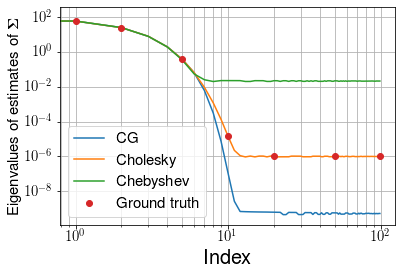

In [38]:
# Plot the distributions of the eigenvalues
markers_on = [1,2,5,10,20,50,99]

plt.figure()
plt.loglog(eig_CG,label=r"CG")
plt.loglog(eig_Chol,label=r"Cholesky")
plt.loglog(eig_Cheby,label=r"Chebyshev")
plt.loglog(np.linalg.eigvals(A).real,'o',markevery = markers_on,label=r"Ground truth")
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel(r"Index",size=20)
plt.ylabel(r"Eigenvalues of estimates of $\mathbf{\Sigma}$",size=15)
plt.grid(True,which='both')
print(int(K_Cheby))

## Figure 6

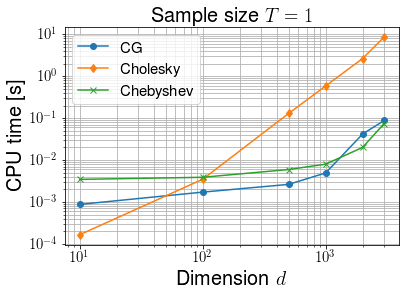

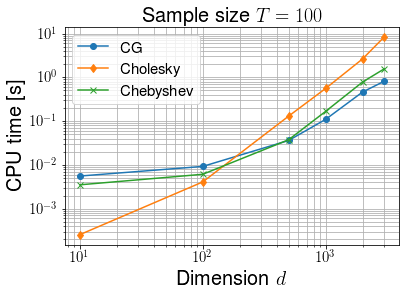

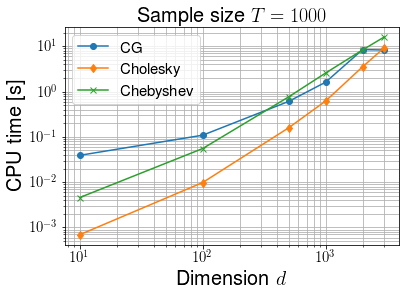

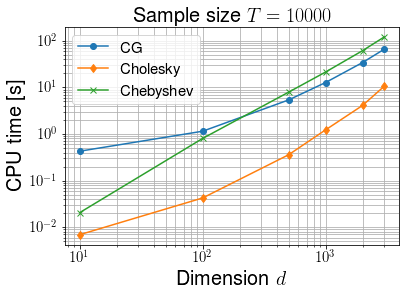

In [43]:
# Load data
Time = np.load('data/time.npy')

# Params
I = [0,2,3,4]
S = [1,100,1000,10000]
D = [10,100,500,1000,2000,3000]

# Figures
k = 0
for i in I:
    plt.figure()
    plt.loglog(D,Time[1,i,:],'-o',label="CG")
    plt.loglog(D,Time[0,i,:],'-d',label="Cholesky")
    plt.loglog(D,Time[2,i,:],'-x',label="Chebyshev")
    plt.legend(prop={'size': 15})
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.xlabel(r"Dimension $d$",size=20)
    plt.ylabel(r"CPU time [s]",size=20)
    plt.title(r"Sample size $T = %i$"%S[k],size=20)
    plt.grid(True, which="both")
    k += 1

## Figure 7

#### Covariance matrix $\tilde{\Sigma}$

<ipython-input-74-6635a1bf2e37>:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))


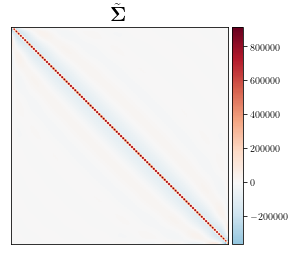

In [76]:
vmin = np.min(invA)
vmax = np.max(invA)
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
plt.figure()
plt.xticks([], [])
plt.yticks([], [])
plt.title(r"$\tilde{\mathbf{\Sigma}}$",size=20)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(invA,aspect='equal',norm=norm,cmap='RdBu_r')
plt.yscale('symlog')
cb = plt.colorbar(im,cax=cax)
cb.ax.tick_params(labelsize=10)

#### Residuals

<ipython-input-1-6635a1bf2e37>:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))


Sampling done for d = 100.
Sampling done for size = 100000.


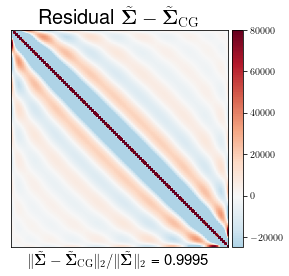

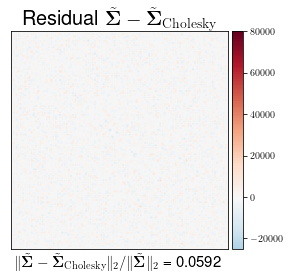

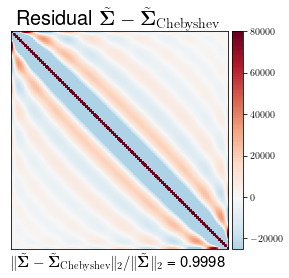

In [3]:
# Set seed
np.random.seed(90)
S = [100000]
D = [100]

# Initialization
err_CG = np.zeros(len(D))
err_Chol = np.zeros(len(D))
err_Cheby = np.zeros(len(D))
K_Cheby = np.zeros((len(S),len(D)))

Time = np.zeros((3,len(S),len(D)))

eig_CG = np.zeros(100)
eig_Chol = np.zeros(100)
eig_Cheby = np.zeros(100)

for t in range(len(S)):
    for i in range(len(D)):

        size = S[t]
        d = D[i]
        A = np.zeros((d,d))
        a = 1.5
        eps = 1e-6
        s = np.linspace(-3,3,num=d)
        for j in range(d):
            for k in range(d):
                if j == k:
                    A[j,k] = 2 + eps
                else:
                    A[j,k] = 2 * np.exp(-(s[j]-s[k])**2 / (2 * a**2))
                    
        invA = np.linalg.inv(A)

        lam_l = np.min(np.linalg.eigvals(A).real)
        lam_u = np.max(np.linalg.eigvals(A).real)
        mu = np.zeros(d)
        init = mu
        def B(x):
            return A.dot(x)
        start = timer()
        theta_Chol = direct_sampling.sampler_factorization(mu=mu,A=A,mode="precision",method="Cholesky",size=size)
        Time[0,t,i] = timer() - start
        start = timer()
        theta_CG = direct_sampling.sampler_CG(mu=mu,tol=1e-4,init=init,A=B,K=8,mode='precision',size=size,info=False)
        Time[1,t,i] = timer() - start
        start = timer()
        [theta_Cheby,K_Cheby[t,i]] = direct_sampling.sampler_squareRootApprox(mu=mu,K=100,A=B,lam_l=lam_l,lam_u=lam_u,tol=1e-4,
                                                               mode="precision",size=size,info=True)
        Time[2,t,i] = timer() - start

        # Performance results
        invA_CG = EmpiricalCovariance().fit(theta_CG.T).covariance_
        invA_Chol = EmpiricalCovariance().fit(theta_Chol.T).covariance_
        invA_Cheby = EmpiricalCovariance().fit(theta_Cheby.T).covariance_
        
        ## Relative error
        err_CG[i] = np.linalg.norm(invA_CG - invA,2) / np.linalg.norm(invA,2)
        err_Chol[i] = np.linalg.norm(invA_Chol - invA,2) / np.linalg.norm(invA,2)
        err_Cheby[i] = np.linalg.norm(invA_Cheby - invA,2) / np.linalg.norm(invA,2)

        ## Plot estimated matrices if d = 100
        if d == 100 and size == 100000:
            
            vmin = np.min(invA-invA_CG)
            vmax = np.max(invA-invA_CG)
            norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
            plt.figure()
            plt.xticks([], [])
            plt.yticks([], [])
            plt.title(r"Residual $\tilde{\mathbf{\Sigma}} - \tilde{\mathbf{\Sigma}}_{\mathrm{CG}}$",size=20)
            plt.xlabel(r"$\Vert\tilde{\mathbf{\Sigma}}-\tilde{\mathbf{\Sigma}}_{\mathrm{CG}}\Vert_2/\Vert\tilde{\mathbf{\Sigma}}\Vert_2$ = %.4f"%err_CG,size=15)
            ax = plt.gca()
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            im = ax.imshow(invA-invA_CG,aspect='equal',norm=norm,cmap='RdBu_r')
            cb = plt.colorbar(im, cax=cax)
            im.set_clim(-25000,80000)
            cb.ax.tick_params(labelsize=10)
            plt.savefig("simu1_ex1_invA_CG.pdf",bbox_inches='tight')
            
            
            vmin = np.min(invA-invA_Chol)
            vmax = np.max(invA-invA_Chol)
            norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
            plt.figure()
            plt.xticks([], [])
            plt.yticks([], [])
            plt.title(r"Residual $\tilde{\mathbf{\Sigma}} - \tilde{\mathbf{\Sigma}}_{\mathrm{Cholesky}}$",size=20)
            plt.xlabel(r"$\Vert\tilde{\mathbf{\Sigma}}-\tilde{\mathbf{\Sigma}}_{\mathrm{Cholesky}}\Vert_2/\Vert\tilde{\mathbf{\Sigma}}\Vert_2$ = %.4f"%err_Chol,size=15)
            ax = plt.gca()
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            im = ax.imshow(invA-invA_Chol,aspect='equal',norm=norm,cmap='RdBu_r')
            cb = plt.colorbar(im, cax=cax)
            im.set_clim(-25000,80000)
            cb.ax.tick_params(labelsize=10)
            plt.savefig("simu1_ex1_invA_Chol.pdf",bbox_inches='tight')
            
            vmin = np.min(invA-invA_Cheby)
            vmax = np.max(invA-invA_Cheby)
            norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
            plt.figure()
            plt.xticks([], [])
            plt.yticks([], [])
            plt.title(r"Residual $\tilde{\mathbf{\Sigma}} - \tilde{\mathbf{\Sigma}}_{\mathrm{Chebyshev}}$",size=20)
            plt.xlabel(r"$\Vert\tilde{\mathbf{\Sigma}}-\tilde{\mathbf{\Sigma}}_{\mathrm{Chebyshev}}\Vert_2/\Vert\tilde{\mathbf{\Sigma}}\Vert_2$ = %.4f"%err_Cheby,size=15)
            ax = plt.gca()
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            im = ax.imshow(invA-invA_Cheby,aspect='equal',norm=norm,cmap='RdBu_r')
            cb = plt.colorbar(im, cax=cax)
            im.set_clim(-25000,80000)
            cb.ax.tick_params(labelsize=10)
            plt.savefig("simu1_ex1_invA_Cheby.pdf",bbox_inches='tight')

        ## Estimated eigenvalues
        if d == 100 and size == 100000:
            eig_CG = np.linalg.eigvals(invA_CG).real
            eig_Chol = np.linalg.eigvals(invA_Chol).real
            eig_Cheby = np.linalg.eigvals(invA_Cheby).real

        print('Sampling done for d = %i.'%d)
    print('Sampling done for size = %i.'%size)

#### Eigenvalues

97


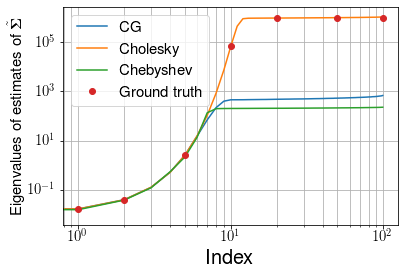

In [46]:
# Plot the distributions of the eigenvalues
markers_on = [1,2,5,10,20,50,99]

plt.figure()
plt.loglog(np.sort(eig_CG),label=r"CG")
plt.loglog(np.sort(eig_Chol),label=r"Cholesky")
plt.loglog(np.sort(eig_Cheby),label=r"Chebyshev")
plt.loglog(np.sort(np.linalg.eigvals(invA).real),'o',markevery = markers_on,label=r"Ground truth")
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel(r"Index",size=20)
plt.ylabel(r"Eigenvalues of estimates of $\tilde{\mathbf{\Sigma}}$",size=15)
plt.grid(True,which='both')
print(int(K_Cheby))

## Figure 8

#### Covariance matrix $\Sigma$

C:\mvono\anaconda\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


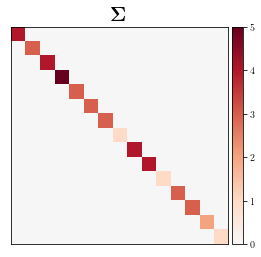

In [7]:
np.random.seed(90)
d = 15
A = np.diag(np.random.randint(1,6,d))
mu = np.zeros(d)
init = mu
size = 100000

vmin = np.min(A)
vmax = np.max(A)
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=1e-3)
plt.figure()
plt.xticks([], [])
plt.yticks([], [])
plt.title(r"$\mathbf{\Sigma}$",size=20)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(A,aspect='equal',norm=norm,cmap='RdBu_r')
cb = plt.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=10)

#### Residuals

<ipython-input-1-6635a1bf2e37>:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))


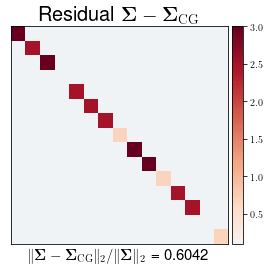

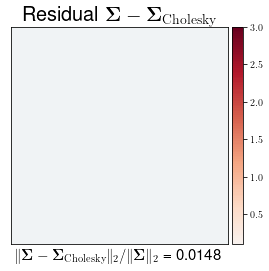

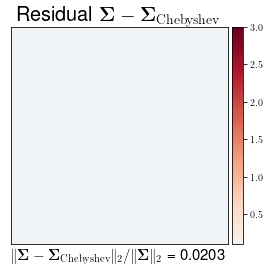

In [4]:
np.random.seed(90)
d = 15
A = np.diag(np.random.randint(1,6,d))
mu = np.zeros(d)
init = mu
size = 100000

lam_l = np.min(np.diag(A))
lam_u = np.max(np.diag(A))
def B(x):
    return A.dot(x)
theta_Chol = direct_sampling.sampler_factorization(mu=mu,A=A,mode="covariance",method="Cholesky",size=size)
theta_CG = direct_sampling.sampler_CG(mu=mu,tol=1e-4,init=init,A=B,K=d,mode='covariance',size=size,info=True)
[theta_Cheby,K_Cheby] = direct_sampling.sampler_squareRootApprox(mu=mu,K=100,A=B,lam_l=lam_l,lam_u=lam_u,tol=1e-4,
                                                               mode="covariance",size=size,info=True)
A_CG = EmpiricalCovariance().fit(theta_CG[0].T).covariance_
A_Chol = EmpiricalCovariance().fit(theta_Chol.T).covariance_
A_Cheby = EmpiricalCovariance().fit(theta_Cheby.T).covariance_
        
## Relative error
err_CG = np.linalg.norm(A_CG - A,2) / np.linalg.norm(A,2)
err_Chol = np.linalg.norm(A_Chol - A,2) / np.linalg.norm(A,2)
err_Cheby = np.linalg.norm(A_Cheby - A,2) / np.linalg.norm(A,2)

# Figures
vmin = np.min(A-A_CG)
vmax = np.max(A-A_CG)
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
plt.figure()
plt.xticks([], [])
plt.yticks([], [])
plt.title(r"Residual $\mathbf{\Sigma} - \mathbf{\Sigma}_{\mathrm{CG}}$",size=20)
plt.xlabel(r"$\Vert\mathbf{\Sigma}-\mathbf{\Sigma}_{\mathrm{CG}}\Vert_2/\Vert\mathbf{\Sigma}\Vert_2$ = %.4f"%err_CG,size=15)   
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(A-A_CG,aspect='equal',norm=norm,cmap='RdBu_r')
cb = plt.colorbar(im, cax=cax)
im.set_clim(0.1,3)
cb.ax.tick_params(labelsize=10)
plt.savefig("simu1_ex2_A_CG.pdf",bbox_inches='tight')

vmin = np.min(A-A_Chol)
vmax = np.max(A-A_Chol)
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
plt.figure()
plt.xticks([], [])
plt.yticks([], [])
plt.title(r"Residual $\mathbf{\Sigma} - \mathbf{\Sigma}_{\mathrm{Cholesky}}$",size=20)
plt.xlabel(r"$\Vert\mathbf{\Sigma}-\mathbf{\Sigma}_{\mathrm{Cholesky}}\Vert_2/\Vert\mathbf{\Sigma}\Vert_2$ = %.4f"%err_Chol,size=15)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(A-A_Chol,aspect='equal',norm=norm,cmap='RdBu_r')
cb = plt.colorbar(im, cax=cax)
im.set_clim(0.1,3)
cb.ax.tick_params(labelsize=10)
plt.savefig("simu1_ex2_A_Chol.pdf",bbox_inches='tight')

vmin = np.min(A-A_Cheby)
vmax = np.max(A-A_Cheby)
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
plt.figure()
plt.xticks([], [])
plt.yticks([], [])
plt.title(r"Residual $\mathbf{\Sigma} - \mathbf{\Sigma}_{\mathrm{Chebyshev}}$",size=20)
plt.xlabel(r"$\Vert\mathbf{\Sigma}-\mathbf{\Sigma}_{\mathrm{Chebyshev}}\Vert_2/\Vert\mathbf{\Sigma}\Vert_2$ = %.4f"%err_Cheby,size=15)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
im = ax.imshow(A-A_Cheby,aspect='equal',norm=norm,cmap='RdBu_r')
cb = plt.colorbar(im, cax=cax)
im.set_clim(0.1,3)
cb.ax.tick_params(labelsize=10)
plt.savefig("simu1_ex2_A_Cheby.pdf",bbox_inches='tight')

#### Eigenvalues

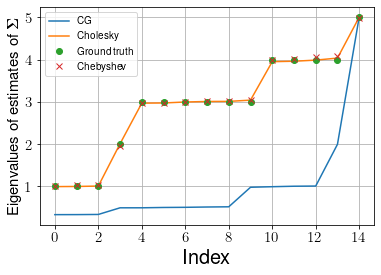

In [18]:
# Eigenvalues
eig_CG = np.linalg.eigvals(A_CG).real
eig_Chol = np.linalg.eigvals(A_Chol).real
eig_Cheby = np.linalg.eigvals(A_Cheby).real

plt.figure()
plt.plot(np.sort(eig_CG),label=r"CG")
plt.plot(np.sort(eig_Chol),label=r"Cholesky")
plt.plot(np.sort(np.diag(A)),'o',markevery = 1,label=r"Ground truth")
plt.plot(np.sort(eig_Cheby),'x',markevery = 1,label=r"Chebyshev")
plt.legend(prop={'size': 10})
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel(r"Index",size=20)
plt.ylabel(r"Eigenvalues of estimates of $\mathbf{\Sigma}$",size=15)
plt.grid()
plt.savefig('aaa.pdf', bbox_inches='tight')

## Figure 9

<ipython-input-1-6635a1bf2e37>:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  return sp.ma.masked_array(sp.interp(value, x, y))


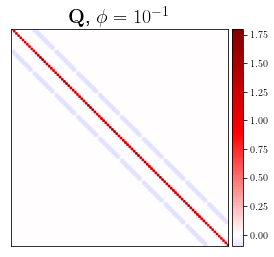

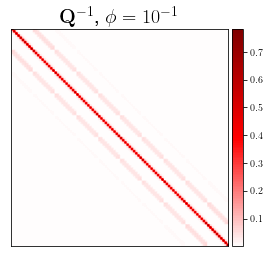

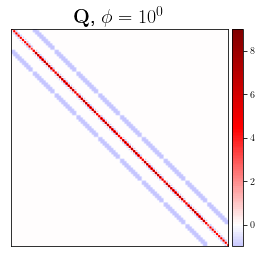

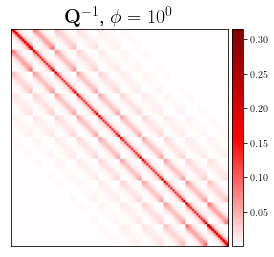

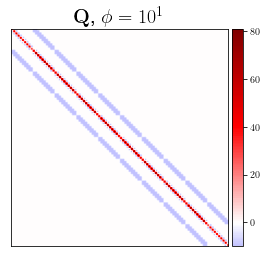

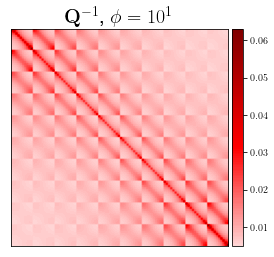

In [3]:
def neighbors(cell):
    for c in product(*(range(n-1, n+2) for n in cell)):
        if c != cell and all(0 <= n < X for n in c):
            yield c

d = 10**2
X = int(np.sqrt(d))
Y = int(np.sqrt(d))
epsilon = 1
Phi = [0.1,1,10]

for k in range(len(Phi)):
    A = np.zeros((d,d))
    phi = Phi[k]
    for i in range(d):
        for j in range(d):   
            pix_1 = int(i/X)
            pix_2 = i - X * pix_1
            pix_11 = int(j/X)
            pix_22 = j - X * pix_11
            neigh = list(neighbors((pix_1,pix_2)))
            if i==j:
                A[i,j] = epsilon + np.abs(phi) * len(neigh)
            elif i != j and (pix_11,pix_22) in neigh:
                A[i,j] = -phi
            else:
                A[i,j] = 0
            
    # Plot matrix Q
    vmin = np.min(A)
    vmax = np.max(A)
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
    plt.figure()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(r"$\mathbf{Q}$, $\phi = 10^{%i}$"%np.log10(phi),size=20)
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(A,aspect='equal',cmap='seismic',norm=norm)
    cb = plt.colorbar(im, cax=cax)
    cb.ax.tick_params(labelsize=10)
    
    # Plot matrix Q^{-1}
    Q = np.linalg.inv(A)
    vmin = np.min(Q)
    vmax = np.max(Q)
    norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
    plt.figure()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(r"$\mathbf{Q}^{-1}$, $\phi = 10^{%i}$"%np.log10(phi),size=20)
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(Q,aspect='equal',cmap='seismic',norm=norm)
    cb = plt.colorbar(im, cax=cax)
    cb.ax.tick_params(labelsize=10)

## Table 8

#### Spectral radius

In [4]:
d = 10**2
X = int(np.sqrt(d))
Y = int(np.sqrt(d))
epsilon = 1
Phi = [0.1,1,10]

for k in range(len(Phi)):
    A = np.zeros((d,d))
    phi = Phi[k]
    for i in range(d):
        for j in range(d):   
            pix_1 = int(i/X)
            pix_2 = i - X * pix_1
            pix_11 = int(j/X)
            pix_22 = j - X * pix_11
            neigh = list(neighbors((pix_1,pix_2)))
            if i==j:
                A[i,j] = epsilon + np.abs(phi) * len(neigh)
            elif i != j and (pix_11,pix_22) in neigh:
                A[i,j] = -phi
            else:
                A[i,j] = 0

    Q = A
    
    print('----')
    print(r'Parameter phi = 10^{%i}'%np.log10(Phi[k]))
    print('----')

    # Gauss-Seidel
    M = np.tril(Q)
    print('Gauss-Seidel spectral radius = %f'%np.max(np.abs(np.linalg.eigvals(np.linalg.inv(M).dot(M-Q)))))

    # SOR with optimal tuning param.
    Dinv = 1 / np.diag(Q)
    J = np.eye(d) - Q * Dinv[:,None]
    rho = np.max(np.abs(np.linalg.eigvals(J)))
    omega = 2 / (1 + np.sqrt(1 - rho**2))
    print('omega = %f'%omega)
    M = np.tril(Q) + (1-omega)/omega * np.diag(Q) * np.eye(d)
    print('SOR spectral radius = %f'%np.max(np.abs(np.linalg.eigvals(np.linalg.inv(M).dot(M-Q)))))

    # Jacobi
    M = np.diag(Q) * np.eye(d)
    print('Jacobi spectral radius = %f'%np.max(np.abs(np.linalg.eigvals(np.linalg.inv(M).dot(M-Q)))))

    # Richardson
    omega = 2/(np.max(np.abs(np.linalg.eigvals(Q))) + np.min(np.abs(np.linalg.eigvals(Q)))) 
    print('omega = %f'%omega)
    M = np.ones(d) / omega * np.eye(d)
    print('Richardson spectral radius = %f'%np.max(np.abs(np.linalg.eigvals(np.linalg.inv(M).dot(M-Q)))))
    
    # Optional : SSOR with optimal tuning param.
    L = np.tril(Q)- np.diag(np.diag(Q))
    J = np.diag(Dinv).dot(L + L.T)
    rho = np.max(np.abs(np.linalg.eigvals(J)))
    omega = 2 / (1 + np.sqrt(2*(1 - rho)))
    print('omega = %f'%omega)
    M = np.tril(Q) + (1-omega)/omega * np.diag(Q) * np.eye(d)
    M = (omega/(2-omega)) * M.dot(np.diag(Dinv).dot(M.T))
    print('SSOR spectral radius = %f'%np.max(np.abs(np.linalg.eigvals(np.linalg.inv(M).dot(M-Q)))))
    
    # Optional : Cheby-SSOR with optimal tuning param.
    L = np.tril(Q)- np.diag(np.diag(Q))
    J = np.diag(Dinv).dot(L + L.T)
    rho = np.max(np.abs(np.linalg.eigvals(J)))
    omega = 2 / (1 + np.sqrt(2*(1 - rho)))
    print('omega = %f'%omega)
    M = np.tril(Q) + (1-omega)/omega * np.diag(Q) * np.eye(d)
    M = (omega/(2-omega)) * M.dot(np.diag(Dinv).dot(M.T))
    lmin = np.min(np.abs(np.linalg.eigvals(np.linalg.inv(M).dot(Q))))
    lmax = np.max(np.abs(np.linalg.eigvals(np.linalg.inv(M).dot(Q))))
    rate = (1-np.sqrt(lmin/lmax))/(1+np.sqrt(lmin/lmax))
    print('Cheby-SSOR spectral radius = %f'%rate)

----
Parameter phi = 10^{-1}
----
Gauss-Seidel spectral radius = 0.199793
omega = 1.049384
SOR spectral radius = 0.118883
Jacobi spectral radius = 0.423536
omega = 0.632774
Richardson spectral radius = 0.367226
omega = 0.964439
SSOR spectral radius = 0.093596
omega = 0.964439
Cheby-SSOR spectral radius = 0.024563
----
Parameter phi = 10^{0}
----
Gauss-Seidel spectral radius = 0.767693
omega = 1.347423
SOR spectral radius = 0.472645
Jacobi spectral radius = 0.874894
omega = 0.146985
Richardson spectral radius = 0.853015
omega = 1.333144
SSOR spectral radius = 0.450308
omega = 1.333144
Cheby-SSOR spectral radius = 0.148493
----
Parameter phi = 10^{1}
----
Gauss-Seidel spectral radius = 0.971502
omega = 1.710988
SOR spectral radius = 0.785221
Jacobi spectral radius = 0.985631
omega = 0.016939
Richardson spectral radius = 0.983061
omega = 1.710095
SSOR spectral radius = 0.901285
omega = 1.710095
Cheby-SSOR spectral radius = 0.521321


#### CPU time

In [13]:
# Params
d = 10**2
X = int(np.sqrt(d))
Y = int(np.sqrt(d))
epsilon = 1

# Fun
def neighbors(cell):
    for c in product(*(range(n-1, n+2) for n in cell)):
        if c != cell and all(0 <= n < X for n in c):
            yield c

#### Choice of phi ####
phi = 10
#######################

A = np.zeros((d,d))
for i in range(d):
    for j in range(d):   
        pix_1 = int(i/X)
        pix_2 = i - X * pix_1
        pix_11 = int(j/X)
        pix_22 = j - X * pix_11
        neigh = list(neighbors((pix_1,pix_2)))
        if i==j:
            A[i,j] = epsilon + np.abs(phi) * len(neigh)
        elif i != j and (pix_11,pix_22) in neigh:
            A[i,j] = -phi
        else:
            A[i,j] = 0

# Initialization
mu = np.zeros(d)
size = 100000
rep = 1 # Change to rep = 20 to reproduce Figure 11
b = np.max(np.abs(np.nonzero(A)[1] - np.nonzero(A)[0]))
theta_GS = np.zeros((rep,d,size))
theta_J = np.zeros((rep,d,size))
theta_R = np.zeros((rep,d,size))
theta_SOR = np.zeros((rep,d,size))
theta_SSOR = np.zeros((rep,d,size))
theta_ChebySSOR = np.zeros((rep,d,size))
theta_Chol = np.zeros((rep,d,size))
theta_Cheby = np.zeros((rep,d,size))
theta_CG = np.zeros((rep,d,size))

for i in range(rep):
    
    print('----')
    print('Repetition n°%i'%i)
    print('----')
    
    # Launch MCMC samplers
    init = np.zeros(d)
    S = mcmc_sampling.sampler_MS(mu,Q=A,ini=init,b=b,band=True,size=size)
    
    # SOR
    start = timer()
    theta_SOR[i,:] = S.exact_MS(method="SOR")
    print('Time (SOR) = %f'%(timer()-start))
    
    # SSOR
    start = timer()
    theta_SSOR[i,:] = S.exact_MS(method="SSOR")
    print('Time (SSOR) = %f'%(timer()-start))
    
    # Cheby-SSOR
    start = timer()
    theta_ChebySSOR[i,:] = S.exact_MS(method="Cheby-SSOR")
    print('Time (Cheby-SSOR) = %f'%(timer()-start))
    
    # Gauss-Seidel
    start = timer()
    theta_GS[i,:] = S.exact_MS(method="Gauss-Seidel")
    print('Time (Gauss-Seidel) = %f'%(timer()-start))
    
    # Jacobi
    start = timer()
    theta_J[i,:] = S.exact_MS(method="Jacobi")
    print('Time (Jacobi) = %f'%(timer()-start))
    
    # Richardson
    start = timer()
    theta_R[i,:] = S.exact_MS(method="Richardson")
    print('Time (Richardson) = %f'%(timer()-start))
    
    # Launch direct samplers
    
    # Cholesky
    start = timer()
    theta_Chol[i,:] = direct_sampling.sampler_factorization(mu=mu,A=A,mode="precision",method="Cholesky",size=size) 
    print('Time (Cholesky) = %f'%(timer()-start))
    
    # CG
    def B(x):
        return A.dot(x)
    start = timer()
    theta_CG[i,:] = direct_sampling.sampler_CG(mu=mu,tol=1e-4,init=mu,A=B,K=d,mode='precision',size=size,info=False)
    print('Time (CG) = %f'%(timer()-start))
    
    # Chebyshev
    lam_l = np.min(np.linalg.eigvals(A).real)
    lam_u = np.max(np.linalg.eigvals(A).real)
    start = timer()
    theta_Cheby[i,:] = direct_sampling.sampler_squareRootApprox(mu=mu,K=500,A=B,lam_l=lam_l,
                                                                          lam_u=lam_u,tol=1e-4,
                                                                          mode="precision",size=size,info=False)
    print('Time (Chebyshev) = %f'%(timer()-start))

----
Repetition n°0
----
Time (SOR) = 14.694966
Time (SSOR) = 31.754890
Time (Cheby-SSOR) = 14.558438
Time (Gauss-Seidel) = 11.092356
Time (Jacobi) = 2.350652
Time (Richardson) = 2.301036
Time (Cholesky) = 0.624404
Time (CG) = 46.223032
Time (Chebyshev) = 7.969171


## Figure 10

In [4]:
S = np.linalg.inv(A)
Tbi = 1000
T = np.logspace(0,2,11) * Tbi
err_GS = np.zeros((rep,len(T)))
err_SOR = np.zeros((rep,len(T)))
err_SSOR = np.zeros((rep,len(T)))
err_ChebySSOR = np.zeros((rep,len(T)))
err_R = np.zeros((rep,len(T)))
err_J = np.zeros((rep,len(T)))
err_Chol = np.zeros((rep,len(T)))
err_Cheby = np.zeros((rep,len(T)))
err_CG = np.zeros((rep,len(T)))

for i in range(len(T)):
    
    print('----')
    print('Iteration n°%i'%i)
    print('----')
    
    for j in range(rep):
        
        chain = theta_GS[j,:,0:int(T[i])]
        S_hat = EmpiricalCovariance().fit(chain.T).covariance_
        err_GS[j,i] = np.linalg.norm(S-S_hat,2)/np.linalg.norm(S,2)
        
        chain = theta_J[j,:,0:int(T[i])]
        S_hat = EmpiricalCovariance().fit(chain.T).covariance_
        err_J[j,i] = np.linalg.norm(S-S_hat,2)/np.linalg.norm(S,2)
        
        chain = theta_R[j,:,0:int(T[i])]
        S_hat = EmpiricalCovariance().fit(chain.T).covariance_
        err_R[j,i] = np.linalg.norm(S-S_hat,2)/np.linalg.norm(S,2)
        
        chain = theta_SOR[j,:,0:int(T[i])]
        S_hat = EmpiricalCovariance().fit(chain.T).covariance_
        err_SOR[j,i] = np.linalg.norm(S-S_hat,2)/np.linalg.norm(S,2)
        
        chain = theta_SSOR[j,:,0:int(T[i])]
        S_hat = EmpiricalCovariance().fit(chain.T).covariance_
        err_SSOR[j,i] = np.linalg.norm(S-S_hat,2)/np.linalg.norm(S,2)
        
        chain = theta_ChebySSOR[j,:,0:int(T[i])]
        S_hat = EmpiricalCovariance().fit(chain.T).covariance_
        err_ChebySSOR[j,i] = np.linalg.norm(S-S_hat,2)/np.linalg.norm(S,2)
        
        chain = theta_Chol[j,:,0:int(T[i])]
        S_hat = EmpiricalCovariance().fit(chain.T).covariance_
        err_Chol[j,i] = np.linalg.norm(S-S_hat,2)/np.linalg.norm(S,2)
        
        chain = theta_CG[j,:,0:int(T[i])]
        S_hat = EmpiricalCovariance().fit(chain.T).covariance_
        err_CG[j,i] = np.linalg.norm(S-S_hat,2)/np.linalg.norm(S,2)
        
        chain = theta_Cheby[j,:,0:int(T[i])]
        S_hat = EmpiricalCovariance().fit(chain.T).covariance_
        err_Cheby[j,i] = np.linalg.norm(S-S_hat,2)/np.linalg.norm(S,2)

----
Iteration n°0
----
----
Iteration n°1
----
----
Iteration n°2
----
----
Iteration n°3
----
----
Iteration n°4
----
----
Iteration n°5
----
----
Iteration n°6
----
----
Iteration n°7
----
----
Iteration n°8
----
----
Iteration n°9
----
----
Iteration n°10
----


<ipython-input-5-dee50ab29c6b>:5: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


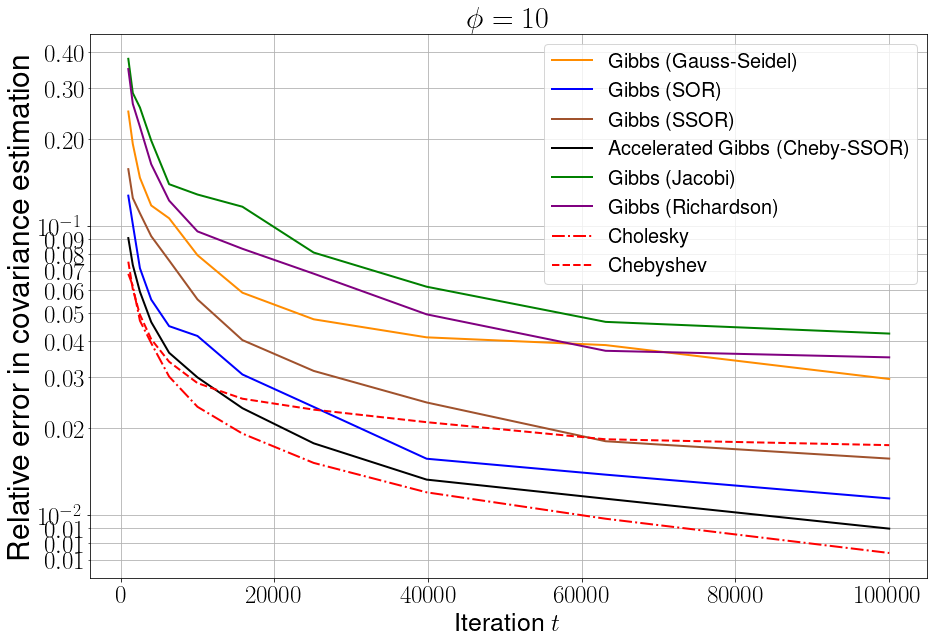

In [5]:
import matplotlib.ticker 

T = np.logspace(0,2,11) * Tbi
#T = np.logspace(1.5,2,100) * Tbi
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
i = 100

# Pre-computing
GS_std = np.std(err_GS[0:i,:],0)
GS_mean = np.mean(err_GS[0:i,:],0)
J_std = np.std(err_J[0:i,:],0)
J_mean = np.mean(err_J[0:i,:],0)
R_std = np.std(err_R[0:i,:],0)
R_mean = np.mean(err_R[0:i,:],0)
SOR_std = np.std(err_SOR[0:i,:],0)
SOR_mean = np.mean(err_SOR[0:i,:],0)
SSOR_std = np.std(err_SSOR[0:i,:],0)
SSOR_mean = np.mean(err_SSOR[0:i,:],0)
ChebySSOR_std = np.std(err_ChebySSOR[0:i,:],0)
ChebySSOR_mean = np.mean(err_ChebySSOR[0:i,:],0)
CG_std = np.std(err_CG[0:i,:],0)
CG_mean = np.mean(err_CG[0:i,:],0)
Chol_std = np.std(err_Chol[0:i,:],0)
Chol_mean = np.mean(err_Chol[0:i,:],0)
Cheby_std = np.std(err_Cheby[0:i,:],0)
Cheby_mean = np.mean(err_Cheby[0:i,:],0)

plt.figure(figsize = (15,10))

plt.plot(T, GS_mean, lw=2, color='darkorange',label="Gibbs (Gauss-Seidel)")
plt.plot(T, SOR_mean, lw=2, color='blue',label="Gibbs (SOR)")
plt.plot(T, SSOR_mean, lw=2, color='sienna',label="Gibbs (SSOR)")
plt.plot(T, ChebySSOR_mean, lw=2, color='black',label="Accelerated Gibbs (Cheby-SSOR)")
plt.plot(T, J_mean, lw=2, color='green',label="Gibbs (Jacobi)")
plt.plot(T, R_mean, lw=2, color='purple',label="Gibbs (Richardson)")
plt.plot(T, Chol_mean,color='red',linestyle='dashdot', lw=2,label="Cholesky")
plt.plot(T, Cheby_mean,color='red',linestyle='--', lw=2,label="Chebyshev")

plt.legend(prop={'size': 20})
plt.xticks(size=25)
plt.yticks(size=25)
ax = plt.gca()
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter(useMathText=True))
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter(useMathText=True))
ax.tick_params(axis="y",which='minor', labelsize=25)
plt.title(r'$\phi = 10$',size=30)
plt.xlabel(r"Iteration $t$",size=25)
plt.ylabel(r"Relative error in covariance estimation",size=30)
plt.grid(True,which="both")
#plt.ylim(0.01,0.3)
plt.savefig("simus2_ex1_convGibbs_phi_10_bis.pdf",bbox_inches='tight')

## Figure 11

##### Build the linear operator associated to the precision matrix

In [69]:
dim = 100
d = dim**2
gam0 = 1
gam = 1

# Laplacian kernel associated to the prior
kerD = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]]) * 1/8
[m0,n0] = np.shape(kerD)
Dpad = np.pad(kerD,[math.floor((dim-m0+1)/2),math.floor((dim-n0)/2)],'constant')
Dpad = np.reshape(np.fft.fftshift(Dpad),(d,))
LambD = np.fft.fft(Dpad)
LambD[0] = gam0
LambD[1:] = LambD[1:] * gam

# Box blur kernel associated to the likelihood
kerH = 1/9 * np.ones((3,3))
[m0,n0] = np.shape(kerH)
Hpad = np.pad(kerH,[math.floor((dim-m0+1)/2),math.floor((dim-n0)/2)],'constant')
Hpad = np.reshape(np.fft.fftshift(Hpad),(d,))
LambH = np.fft.fft(Hpad)

# Precision matrix associated to the noise
kappa1 = 13
kappa2 = 40
Xi = kappa2 * np.random.binomial(1,0.3,d)
Xi[Xi==0] = kappa1

# Matrix Q
if d <= 1000:
    D = circulant(np.reshape(Dpad,(d,)))
    H = circulant(np.reshape(Hpad,(d,)))
    G = np.zeros((d,d))
    G[0,0] = 1
    Q = H.T.dot(np.diag(1/np.reshape(Xi,(d,))).dot(H)) + gam * D.T.dot(D) + (gam0/d) * np.ones((d,d))
    plt.figure()
    plt.imshow(Q,cmap='RdBu_r')
    plt.colorbar()

# Linear operator associated to Q

def A(x):
    idx = x.shape
    Fx = np.fft.fft(x,axis=0)
    A1 = np.fft.ifft(np.fft.fft(np.fft.ifft(Fx * LambH[:,np.newaxis],axis=0).real \
                       * (1/Xi)[:,np.newaxis],axis=0) * LambH.conj()[:,np.newaxis],axis=0).real
    L = np.zeros(d)
    L[0] = gam0
    A2 = np.fft.ifft(Fx * (np.abs(LambD)**2 + L)[:,np.newaxis],axis=0).real
    
    return A1 + A2 

##### Launch the samplers 

In [70]:
mu = np.zeros(d)
size = 10

def Lanczos( A, v, m=100):
    n = len(v)
    if m>n: 
        m = n
    V = np.zeros( (m,n) )
    T = np.zeros( (m,m) )
    vo   = np.zeros(n)
    beta = 0
    for j in range( m-1 ):
        w    = np.reshape(A(np.reshape(v,(n,1))),(n,))
        alfa = np.dot( w, v )
        w    = w - alfa * v - beta * vo
        beta = np.sqrt( np.dot( w, w ) ) 
        vo   = v
        v    = w / beta 
        T[j,j  ] = alfa 
        T[j,j+1] = beta
        T[j+1,j] = beta
        V[j,:]   = v
    w    = np.reshape(A(np.reshape(v,(n,1))),(n,))
    alfa = np.dot( w, v )
    w    = w - alfa * v - beta * vo
    T[m-1,m-1] = np.dot( w, v )
    V[m-1]     = w / np.sqrt( np.dot( w, w ) ) 
    return T, V
v0 = np.random.rand(d)
T, V = Lanczos( A=A, v=v0, m=10 )

# CG sampler
start = timer()
Time = timer() - start
print(Time/size)

# GEDA sampler
rep = 1
size = 10000
theta_DA = np.zeros((rep,d,size))
for i in range(rep):
    S = mcmc_sampling.sampler_DA(mu,size=size)
    start = timer()
    theta_DA[i,:] = S.exact_DA_circu_diag_circu(Lamb1=Xi,LambG1=LambH,LambG2=LambD,A=A,method="GEDA")
    Time = timer() - start
    print(Time/size)
    print(i)

6.689998554065824e-06
0.00734340015000198
0


#### ESS

In [71]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

def my_gelman_rubin(x):
    """ Estimate the marginal posterior variance. Vectorised implementation. """
    m_chains, n_iters = x.shape

    # Calculate between-chain variance
    B_over_n = ((np.mean(x, axis=1) - np.mean(x))**2).sum() / (m_chains - 1)

    # Calculate within-chain variances
    W = ((x - x.mean(axis=1, keepdims=True))**2).sum() / (m_chains*(n_iters - 1))

    # (over) estimate of variance
    s2 = W * (n_iters - 1) / n_iters + B_over_n

    return s2

def my_ESS(x):
    """ Compute the effective sample size of estimand of interest. Vectorised implementation. """
    m_chains, n_iters = x.shape

    variogram = lambda t: ((x[:, t:] - x[:, :(n_iters - t)])**2).sum() / (m_chains * (n_iters - t))

    post_var = my_gelman_rubin(x)

    t = 1
    rho = np.ones(n_iters)
    negative_autocorr = False

    # Iterate until the sum of consecutive estimates of autocorrelation is negative
    while not negative_autocorr and (t < n_iters):
        rho[t] = 1 - variogram(t) / (2 * post_var)
        negative_autocorr = rho[t] < 0
        t += 1

    return int(m_chains*n_iters / (1 + 2*rho[1:t].sum()))

idx = np.argmax(np.var(theta_DA[0,:,:],1))
rho = np.zeros((rep,size))
ESS = np.zeros(rep)
for i in range(1):
    rho[i,:] = autocorr_func_1d(theta_DA[i,idx,:])
    L = np.min(np.where(rho[i,:] < 0))
    ESS[i] = 1/(1 + 2 * np.sum(rho[i,1:L]))
print('Average sampling rate = %f'%np.mean(ESS))

Average sampling rate = 0.264869


#### Figure

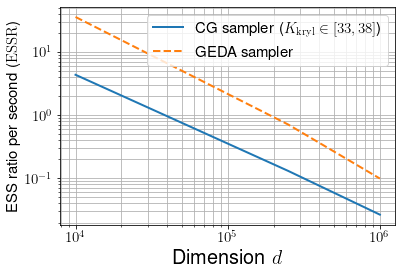

In [73]:
eff_CG = 1/np.array([0.23,7.64,37.53])
eff_DA = 1/np.array([0.028,1.41,10.08])
d1 = [1e4,2.5e5,1e6]
d2 = [1e4,2.5e5,1e6]

plt.figure()
plt.loglog(d1,eff_CG,'-',label=r'CG sampler ($K_{\mathrm{kryl}} \in [33,38]$)',lw=2)
plt.loglog(d2,eff_DA,'--',label=r'GEDA sampler',lw=2)
plt.xlabel(r'Dimension $d$',size=20)
plt.ylabel(r'ESS ratio per second ($\mathrm{ESSR}$)',size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(prop={'size': 15})
plt.grid(True,which="both")
plt.savefig("simu3_ESS_bis.pdf",bbox_inches='tight')